## Libraries and settings


In [2]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

c:\Users\Kevin Keo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


c:\Users\Kevin Keo\OneDrive - ZHAW\Dokumente\Desktop\ZHAW WIN\FS24\KI-Anwendung\Exercise 3


## Import the municipality data


In [3]:
import numpy as np
# Read and select variables
df_orig = pd.read_csv("bfs_municipality_and_tax_data.csv", sep=",", encoding='utf-8')

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
z_scores = np.abs((df['pop'] - df['pop'].mean()) / df['pop'].std())

# Definieren eines Schwellenwerts für den Z-Score
threshold = 3

# Filtern der Datenpunkte, die den Schwellenwert überschreiten
filtered_df = df[z_scores <= threshold]


print(df.shape)
df.head(5)

(2059, 7)


,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,tax_income
0,1,Aeugst am Albis,1981,250.442478,14.184755,442.0,108'788
1,2,Affoltern am Albis,12303,1161.756374,28.700317,6920.0,72'583
2,3,Bonstetten,5572,749.932705,16.564968,1014.0,91'002
3,4,Hausen am Albis,3751,275.808824,16.022394,1021.0,91'766
4,5,Hedingen,3778,578.560490,16.410799,1478.0,94'456


In [4]:
len(df)

2059

In [5]:
df.columns

Index(['bfs_number', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income'],
      dtype='object')

## Umwandlung der Daten

In [6]:

# Laden der Daten (ersetzen Sie 'path_to_your_data.csv' mit dem tatsächlichen Pfad Ihrer CSV-Datei)
df = pd.read_csv('bfs_municipality_and_tax_data.csv')

# Konvertieren der 'tax_income' Spalte, Entfernen der Apostrophe und Umwandlung in int
df['tax_income'] = df['tax_income'].str.replace("'", "").astype(int)

# Überprüfung der Daten nach der Umwandlung
print(df.head())


   bfs_number            bfs_name    pop     pop_dens    frg_pct     emp  \
0           1     Aeugst am Albis   1981   250.442478  14.184755   442.0   
1           2  Affoltern am Albis  12303  1161.756374  28.700317  6920.0   
2           3          Bonstetten   5572   749.932705  16.564968  1014.0   
3           4     Hausen am Albis   3751   275.808824  16.022394  1021.0   
4           5            Hedingen   3778   578.560490  16.410799  1478.0   

   tax_income  
0      108788  
1       72583  
2       91002  
3       91766  
4       94456  


In [13]:
# Spaltenauswahl für die Features, `tax_income` wird nicht in X_train inkludiert
X_train, X_test, y_train, y_test = train_test_split(df[['pop', 'pop_dens']], df['tax_income'], test_size=0.20, random_state=42)


In [14]:
# train linear_model = LinearRegression()
linear_model = LinearRegression()

scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('--{}--'.format(linear_model))
print(scores)
print(np.mean(scores)) 


--LinearRegression()--
[-5.11184266e+08 -9.97282727e+08 -8.18170502e+08 -5.96178621e+08
 -7.58082729e+08]
-736179768.951327


In [15]:
polynomial_model = Pipeline([
                                ("polynomial_features", PolynomialFeatures(degree=2)),
                                ("linear_regression", LinearRegression()),
                            ])

scores = cross_val_score(polynomial_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print('--{}--'.format(polynomial_model))
print(scores)
print(np.mean(scores)) 

--Pipeline(steps=[('polynomial_features', PolynomialFeatures()),
                ('linear_regression', LinearRegression())])--
[-21541.25033263 -30915.50924037 -28060.93191501 -36922.5391216
 -26578.83220757]
-28803.812563433574


In [19]:
randomforest_model = RandomForestRegressor(random_state=42)

scores = cross_val_score(randomforest_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print('--{}--'.format(randomforest_model))
print(scores)
print(np.mean(scores)) 

--RandomForestRegressor(random_state=42)--
[-24694.8440253  -28366.49948419 -29378.19450515 -25096.26590966
 -27832.84598362]
-27073.729981585017


## GridSearchCV


In [11]:
# get_params give the possible configuration. As we see with LinearRegression, there aren't any we can configure, so no GridSerchCV will be performed.
linear_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [12]:
polynomial_model.get_params()

{'memory': None,
 'steps': [('polynomial_features', PolynomialFeatures()),
  ('linear_regression', LinearRegression())],
 'verbose': False,
 'polynomial_features': PolynomialFeatures(),
 'linear_regression': LinearRegression(),
 'polynomial_features__degree': 2,
 'polynomial_features__include_bias': True,
 'polynomial_features__interaction_only': False,
 'polynomial_features__order': 'C',
 'linear_regression__copy_X': True,
 'linear_regression__fit_intercept': True,
 'linear_regression__n_jobs': None,
 'linear_regression__positive': False}

In [16]:
# there are two configurations which can be configuered, degree and bias
# therefor we generate a config

from sklearn.model_selection import GridSearchCV

param_grid = {
'polynomial_features__degree': [2, 4],
'polynomial_features__include_bias': [True, False],
}

grid_search_pl = GridSearchCV(polynomial_model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2) # add param verbose = 2 to see the state
grid_search_pl.fit(X_train, y_train)
print(grid_search_pl.best_estimator_)
print(grid_search_pl.best_params_)
print(grid_search_pl.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=True; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=True; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=True; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=True; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=True; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=False; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=False; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=False; total time=   0.0s
[CV] END polynomial_features__degree=2, polynomial_features__include_bias=False; total time=   0.0s
[CV] END polynomial_features__degree=2, polyn

In [20]:
param_grid = {'max_depth': [90, 100, 110],
'max_features': [6, 9]
}

grid_search_rf = GridSearchCV(randomforest_model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2) # add param verbose = 2 to see the state
grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_estimator_)
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .......................max_depth=90, max_features=6; total time=   0.3s
[CV] END .......................max_depth=90, max_features=6; total time=   0.3s
[CV] END .......................max_depth=90, max_features=6; total time=   0.2s
[CV] END .......................max_depth=90, max_features=6; total time=   0.2s
[CV] END .......................max_depth=90, max_features=6; total time=   0.2s
[CV] END .......................max_depth=90, max_features=9; total time=   0.2s
[CV] END .......................max_depth=90, max_features=9; total time=   0.2s
[CV] END .......................max_depth=90, max_features=9; total time=   0.2s
[CV] END .......................max_depth=90, max_features=9; total time=   0.2s
[CV] END .......................max_depth=90, max_features=9; total time=   0.3s
[CV] END ......................max_depth=100, max_features=6; total time=   0.2s
[CV] END ......................max_depth=100, max

## Datenanalyse


       pop    pop_dens      abs_error
1797  2118  613.913043  359738.274124
2058  2387  616.795866  347598.123991
597   5350  305.714286  230989.434725
2098  2577  583.031674  184994.206152
699    398  222.346369  183496.358237


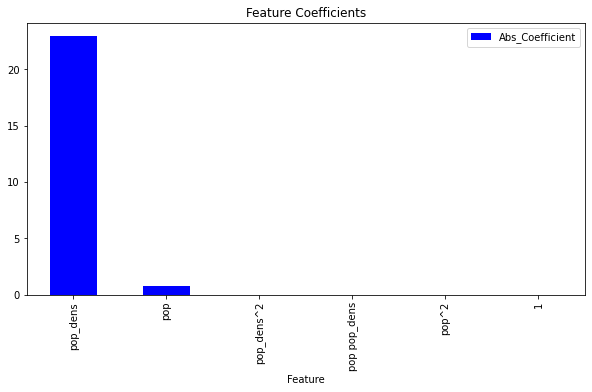

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Annahme: Sie haben bereits die Daten geladen und X_train, y_train definiert
# Polynomial Model definieren
polynomial_model = Pipeline([
    ("polynomial_features", PolynomialFeatures(degree=2)),
    ("linear_regression", LinearRegression())
])

# Modell mit Trainingsdaten trainieren
polynomial_model.fit(X_train, y_train)

# Nun können Sie das Modell verwenden, um Vorhersagen zu machen
y_pred = polynomial_model.predict(X_train)

# Fehler berechnen
errors = y_train - y_pred
abs_errors = np.abs(errors)

# Fehlerdaten zu Trainingsdaten hinzufügen
df_train = pd.DataFrame(X_train, columns=['pop', 'pop_dens'])  # Achten Sie darauf, die korrekten Spaltennamen zu verwenden
df_train['abs_error'] = abs_errors

# Daten nach dem Fehler sortieren und anzeigen
df_train_sorted = df_train.sort_values(by='abs_error', ascending=False)
print(df_train_sorted.head())

# Koeffizienten extrahieren und darstellen, wenn das Modell eine Pipeline ist und die lineare Regression enthält
if 'linear_regression' in polynomial_model.named_steps:
    coefficients = polynomial_model.named_steps['linear_regression'].coef_
    feature_names = polynomial_model.named_steps['polynomial_features'].get_feature_names_out()

    df_coeffs = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    df_coeffs['Abs_Coefficient'] = df_coeffs['Coefficient'].abs()
    df_coeffs.sort_values('Abs_Coefficient', ascending=False, inplace=True)

    import matplotlib.pyplot as plt
    df_coeffs.plot(kind='bar', x='Feature', y='Abs_Coefficient', color='blue', figsize=(10, 5))
    plt.title('Feature Coefficients')
    plt.show()



In [24]:
X_train.columns

Index(['pop', 'pop_dens'], dtype='object')

In [26]:
print(df.columns)



Index(['bfs_number', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income'],
      dtype='object')


In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Definieren des polynomialen Modells
polynomial_model = Pipeline([
    ("polynomial_features", PolynomialFeatures(degree=2)),
    ("linear_regression", LinearRegression())
])



# Trainieren des Modells
polynomial_model.fit(X_train, y_train)

# Holen aller Vorhersagen für den Trainingssatz mittels Cross-Validation
y_train_predict = cross_val_predict(polynomial_model, X_train, y_train, cv=5)

# DataFrame zur Analyse erstellen
df_new = pd.DataFrame(X_train, columns=X_train.columns, copy=True)
df_new['error'] = np.abs(y_train_predict - y_train)
df_new['price'] = y_train
df_new['predicted_price'] = y_train_predict



# Ergebnisse anzeigen
print(df_new.shape)
df_new.head()


(1724, 5)


,pop,pop_dens,error,price,predicted_price
867,5140,368.723099,1954.699260,76335,74380.300740
1606,434,19.727273,9613.355640,60849,70462.355640
1111,1120,24.190065,18203.403546,51836,70039.403546
1258,1469,327.171492,9547.985444,85695,76147.014556
1319,1042,109.568875,5081.069339,66865,71946.069339


Statistische Zusammenfassung der Fehler:
count      1724.000000
mean      14939.597365
std       25152.444228
min          32.041985
25%        4555.686264
50%        9775.227734
75%       16571.647858
max      398890.610838
Name: error, dtype: float64


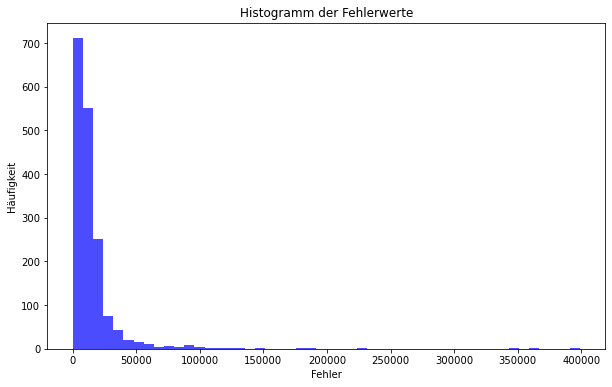

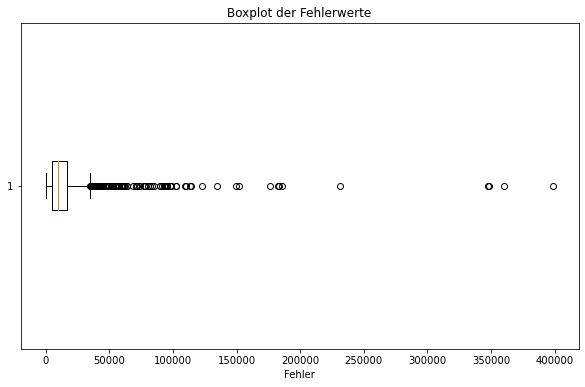

In [28]:
import matplotlib.pyplot as plt

# Statistische Zusammenfassung der Fehler
print("Statistische Zusammenfassung der Fehler:")
print(df_new['error'].describe())

# Histogramm der Fehler
plt.figure(figsize=(10, 6))
plt.hist(df_new['error'], bins=50, color='blue', alpha=0.7)
plt.title('Histogramm der Fehlerwerte')
plt.xlabel('Fehler')
plt.ylabel('Häufigkeit')
plt.show()

# Boxplot der Fehler
plt.figure(figsize=(10, 6))
plt.boxplot(df_new['error'], vert=False)
plt.title('Boxplot der Fehlerwerte')
plt.xlabel('Fehler')
plt.show()


In [29]:
# Filtern der Daten basierend auf einem Fehler größer als 25,000
filtered_data = df_new[df_new['error'] > 25000]

# Speichern der gefilterten Daten in einer CSV-Datei
filtered_data.to_csv('data_with_large_errors.csv', sep=",", encoding='utf-8', index=False)


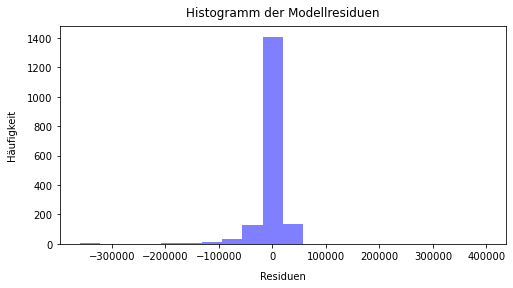

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Definieren des polynomialen Modells
polynomial_model = Pipeline([
    ("polynomial_features", PolynomialFeatures(degree=2)),
    ("linear_regression", LinearRegression())
])

# Holen aller Vorhersagen für den Trainingssatz mittels Cross-Validation
y_train_predict = cross_val_predict(polynomial_model, X_train, y_train, cv=5)

# Berechnen der Residuen
y_residuals = y_train_predict - y_train

# Histogramm der Residuen
fig = plt.figure(figsize=(8, 4))
n, bins, patches = plt.hist(x=y_residuals, bins=20, color='blue', alpha=0.5)

# Beschriftungen setzen
plt.xlabel('Residuen', fontsize=10, labelpad=10)
plt.ylabel('Häufigkeit', fontsize=10, labelpad=10)
plt.title('Histogramm der Modellresiduen', fontsize=12, pad=10)
plt.show()


## Modell speichern

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df[['pop', 'pop_dens']], df['tax_income'], test_size=0.20, random_state=42)

polynomial_model.fit(X_train, y_train)


Pipeline(steps=[('polynomial_features', PolynomialFeatures()),
                ('linear_regression', LinearRegression())])

In [36]:
import pickle

# save model to file
model_filename = "polynomial_model.pkl"
with open(model_filename, mode="bw") as f:
    pickle.dump(polynomial_model, file=f)
